# PyRoomAcoustics Room Simulator

Documentation: https://pyroomacoustics.readthedocs.io/en/pypi-release/pyroomacoustics.room.html#pyroomacoustics.room.Room.add

# Importing the relevant libraries

In [549]:
import numpy as np
import matplotlib.pyplot as plt
import pyroomacoustics as pra
from pydub import AudioSegment

# Setting the dimensions of the room

Inverse Sabine's Formula: 

In [550]:
# file_path = 'sounds/A440.wav'
file_path = 'sounds/timer.wav'
# file_path = 'sounds/sweep.wav'

# import a mono wavfile as the source signal
# the sampling frequency should match that of the room
from scipy.io import wavfile

def stereo_to_mono_array(file_path):
    # Load stereo audio file
    audio = AudioSegment.from_wav(file_path)

    # Convert stereo to mono
    mono_audio = audio.set_channels(1)

    # Export mono audio to WAV file
    mono_audio.export(f"{file_path}_mono.wav", format="wav")

stereo_to_mono_array(file_path)
fs, audio = wavfile.read(f"{file_path}_mono.wav")
print(audio)
# The desired reverberation time and dimensions of the room
rt60_tgt = 0.5   # seconds
room_dim = [3, 3, 3]  # meters
L = 1.28     # Distance between microphones (meters)
mic_h = 1    # Assume microphone is 1m from the ground

# We invert Sabine's formula to obtain the parameters for the ISM simulator
e_absorption, max_order = pra.inverse_sabine(rt60_tgt, room_dim)

# Create the room
room = pra.ShoeBox(
    room_dim, fs=fs, materials=pra.Material(e_absorption), max_order=max_order,
    use_rand_ism = True, max_rand_disp = 0.05
)

# # Assume a room without any sort of absorption
# room = pra.ShoeBox(
#     room_dim, fs=fs,
# )

FileNotFoundError: [Errno 2] No such file or directory: 'sound/timer.wav'

# Adding sources

In [ ]:
# Offsets from origin: Set a 1m offset from the origin
x_offset = 1
y_offset = 1

# Source position
source_pos = [x_offset + L/4, y_offset + np.sqrt(3)*L/4, mic_h]

# place the source in the room
room.add_source(source_pos, signal=audio)


# Adding Microphones

We need to use ambisonic microphones that can record 3D sound. Looking into this beamforming function which allows us to set the directivity of the microphones: https://pyroomacoustics.readthedocs.io/en/pypi-release/pyroomacoustics.beamforming.html

In [ ]:
# Microphone positions
mic_1_pos  = [x_offset + 0, y_offset + 0, mic_h]
mic_2_pos  = [x_offset + L, y_offset + 0, mic_h]
mic_3_pos  = [x_offset + L/2, y_offset + np.sqrt(3)*L/2, mic_h]
mic_gt_pos = [x_offset + L/2, y_offset + np.sqrt(3)*L/6, mic_h]

# [NORMAL MICROPHONES] Define the locations of the microphones
mic_locs = np.c_[
    mic_1_pos,  # mic 1
    mic_2_pos,  # mic 2
    mic_3_pos,  # mic 3
    mic_gt_pos  # ground truth microphone
]
print(mic_locs)

# finally place the array in the room
room.add_microphone_array(mic_locs)


[[1.         2.28       1.64       1.64      ]
 [1.         1.         2.10851252 1.36950417]
 [1.         1.         1.         1.        ]]


# Running the simulation
Note: This will build the RIR automatically

In [ ]:
# Simulate the room
room.simulate()

# Output the microphone data to wav file format
room.mic_array.to_wav(
    f"generated_mics/mic_arr.wav",
    norm=True,
    bitdepth=np.int16,
)

# Creating the room impulse response

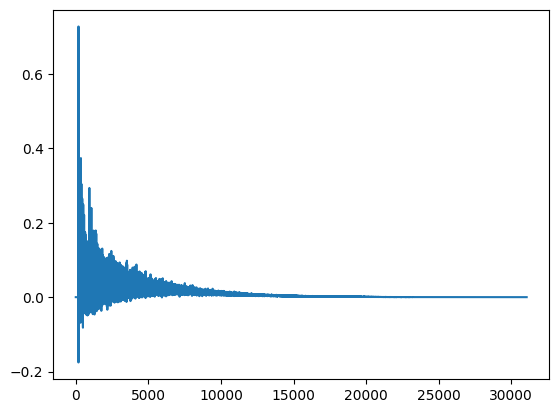

In [ ]:
room.compute_rir()
plt.plot(room.rir[1][0])
plt.show()

# Plot the room output

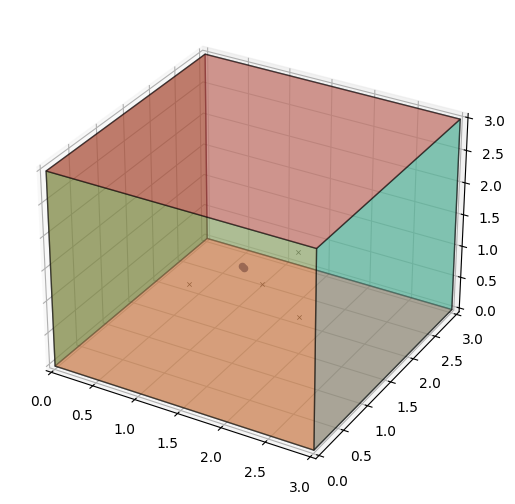

In [ ]:
room.plot(img_order=0)
plt.show()

# Simulate sound propagation

The desired RT60 was 0.5
The measured RT60 is 0.49158730158730163


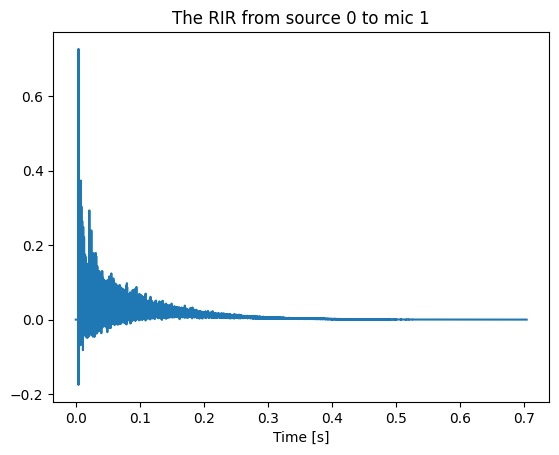

[[ 2.35475140e-11  1.05963813e-11 -4.70950280e-12 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 1.41285084e-11  5.88687850e-12  9.41900559e-12 ... -1.17737570e-12
   5.29819065e-12  1.64832598e-11]
 [ 9.41900559e-12  1.64832598e-11  4.70950280e-11 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 4.70950280e-12  6.47556635e-12  3.53212710e-12 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]]


In [ ]:
# measure the reverberation time
rt60 = room.measure_rt60()
print("The desired RT60 was {}".format(rt60_tgt))
print("The measured RT60 is {}".format(rt60[1, 0]))

# Create a plot
plt.figure()

# plot one of the RIR. both can also be plotted using room.plot_rir()
rir_1_0 = room.rir[1][0]
# plt.subplot(5, 1, 1)
plt.plot(np.arange(len(rir_1_0)) / room.fs, rir_1_0)
plt.title("The RIR from source 0 to mic 1")
plt.xlabel("Time [s]")
plt.show()

# Plotting individual signals

start = 10000
end = 12000

print(room.mic_array.signals)

# plot signal at microphone 1
# mic_1_signal = room.mic_array.signals[0, :]
# mic_1_signal = mic_1_signal[start:end]# Shorten the signal
# # plt.subplot(5, 1, 2)
# plt.plot(mic_1_signal)
# plt.title("Microphone 1 signal")
# plt.xlabel("Time [s]")
# plt.show()

# # plot signal at microphone 2
# mic_2_signal = room.mic_array.signals[1, :]
# mic_2_signal = mic_2_signal[start:end]# Shorten the signal
# # plt.subplot(5, 1, 3)
# plt.plot(mic_2_signal, color='red')
# plt.title("Microphone 2 signal")
# plt.xlabel("Time [s]")
# plt.show()

# # plot signal at microphone 2
# mic_3_signal = room.mic_array.signals[2, :]
# mic_3_signal = mic_3_signal[start:end]# Shorten the signal
# # plt.subplot(5, 1, 4)
# plt.plot(mic_3_signal, color='green')
# plt.title("Microphone 3 signal")
# plt.xlabel("Time [s]")
# plt.show()

# # plot signal at microphone 2
# gt_signal = room.mic_array.signals[3, :]
# gt_signal = gt_signal[start:end]# Shorten the signal
# # plt.subplot(5, 1, 5)
# plt.plot(mic_3_signal, color='orange')
# plt.title("Ground Truth signal")
# plt.xlabel("Time [s]")
# plt.show()

# Analysis of the simulations

Able to successfully print out what each microphone hears. 

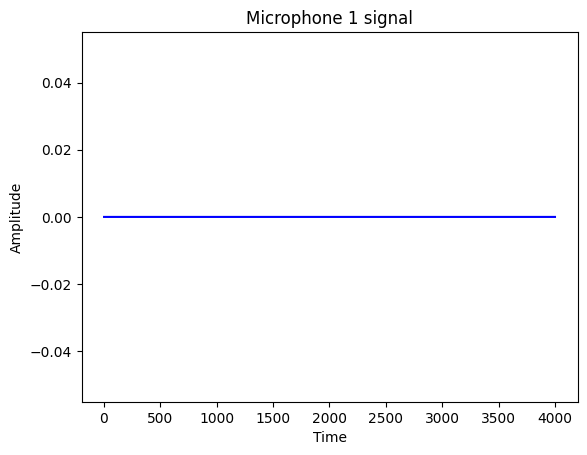

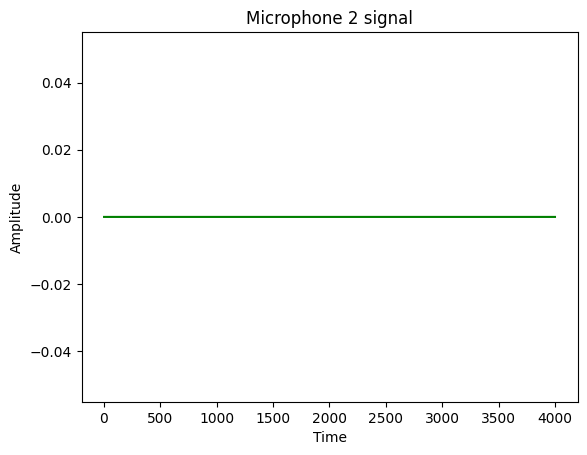

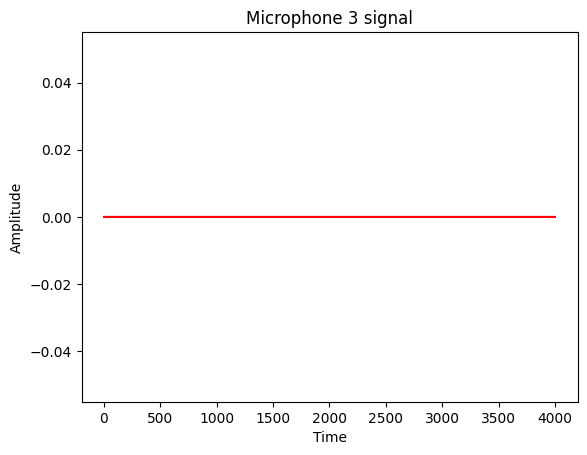

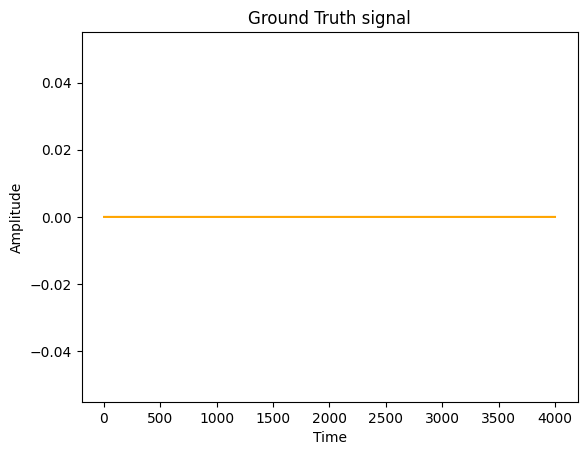

In [ ]:
from scipy.io import wavfile
fs, audio = wavfile.read('generated_mics/mic_arr.wav')

# Define start and end point
start = 10000
end = 14000

# Getting each of the individual components (Omnidirectional components)
mic_1_signal  = audio[:, 1]
mic_2_signal  = audio[:, 0]
mic_3_signal  = audio[:, 2]
mic_gt_signal = audio[:, 3]

# Shortening each of the signals
mic_1_signal_shortened = mic_1_signal[start:end]
mic_2_signal_shortened = mic_2_signal[start:end]
mic_3_signal_shortened = mic_3_signal[start:end]
mic_gt_signal_shortened = mic_gt_signal[start:end]

# Plotting each of the signals
def plot_signal(time, signal, title, color='blue'):
    plt.plot(time, signal, color)
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.show()

# Plotting each of the signals
time_axis = np.arange(1, mic_1_signal_shortened.shape[0] + 1)

plot_signal(time_axis, mic_1_signal_shortened, 'Microphone 1 signal', color='blue')
plot_signal(time_axis, mic_2_signal_shortened, 'Microphone 2 signal', color='green')
plot_signal(time_axis, mic_3_signal_shortened, 'Microphone 3 signal', color='red')
plot_signal(time_axis, mic_gt_signal_shortened, 'Ground Truth signal', color='orange')

# Applying the Interpolation Algorithm
In this section, we will apply the interpolation algorithm for the omnidirectional component. 

In [ ]:
# Step 1: Define the parameters

# Reference: Patricio et. al in [14] E. Patricio, A. Ruminski, A. Kuklasinski, 
# L. Januszkiewicz, and T. Zernicki, "Toward Six Degrees of Freedom Audio 
# Recording and Playback Using Multiple Ambisonics Sound Fields," Paper 10141, 
# (2019 March.)

# Number of microphones
M = 3

# Order of Ambisonics
# We are using first order ambisonics in FuMa Format
# Note: WAV Format: W,X,Y,Z
P = 1

# Placing the ambisonic microphones in a triangle, this is the length of the 
# triangle (in centimeters)
triangle_side = L

# Constants for the attenuation function
volume_threshold = 0.9
volume_range = 0.9
hoa_threshold = 0.9
hoa_range = 1.3

# Defining the indices of the channel
w_channel = 0
x_channel = 1
y_channel = 2
z_channel = 3

# Defining the microphone positions as a global parameter
mic_positions = np.zeros((3, 2))

mic_positions[0, :] = [mic_1_pos[0], mic_1_pos[1]]
mic_positions[1, :] = [mic_2_pos[0], mic_2_pos[1]]
mic_positions[2, :] = [mic_3_pos[0], mic_3_pos[1]]

# Defining certain functions

In [ ]:

def attenuation_and_rebalancing(d_m, t_l=volume_threshold, t_k=hoa_range, s_k_0=1.0, s_k_p_neg=-1.0, s_l_neg=-1.0):
    """
    Distance-dependent attenuation and component re-balancing function.

    Parameters:
    - d_m: distance to the m-th microphone
    - t_l: attenuation threshold
    - t_k: re-balancing threshold
    - s_k_0: slope for the 0th order component
    - s_k_p_neg: slope for higher-order components (p>0)
    - s_l_neg: slope for overall gain

    Returns:
    - Attenuation coefficient for the given distance
    """
    # Equation (3)
    def l(d_m):
        # Piecewise function where: 
        # l(d_m) = 0 if d_m <= t_l
        # l(d_m) = s_l(d_m - t_l) otherwise
        return np.where(d_m <= t_l, 0, s_l(d_m - t_l))

    # Equation (4)
    def k_p(d_m):
        # Piecewise function where: 
        # k_p(d_m) = 0 if d_m <= t_k
        # k_p(d_m) = s_k_p(d_m - t_k) otherwise
        return np.where(d_m <= t_k, 0, s_k_p(d_m - t_k))

    # Component in equation (3)
    def s_l(delta_d):
        # Adjust this function based on the specific behavior of s_l
        # For example, you can use a linear function: return s_l_neg * delta_d
        return s_l_neg * delta_d

    # Component in equation (4)
    def s_k_p(delta_d):
        # Adjust this function based on the specific behavior of s_k_p
        # For p=0, the slope is positive; for p>0, the slope is negative
        return np.where(delta_d <= 0, s_k_0, s_k_p_neg * delta_d)

    # Equation (2)
    return 10 ** ((l(d_m) + k_p(d_m)) / 20.0)

# Function to compute the distance between the interpolation points and the microphone
def compute_distance(interp_point, mic_number, triangle_side):
    
    # Euclidean distance between the interpolation point and the microphone

    distance = np.linalg.norm(interp_point - mic_positions[mic_number, :])
    return distance

# Function to extract the w, x, y, z channel signals
def extract_channels(mic_signal):
    # W Channel (Omni directional)
    w_signal = mic_signal[:, w_channel].astype(float)
    # X Channel
    x_signal = mic_signal[:, x_channel].astype(float)
    # Y Channel
    y_signal = mic_signal[:, w_channel].astype(float)
    # Z Channel
    z_signal = mic_signal[:, w_channel].astype(float)

    return w_signal, x_signal, y_signal, z_signal

# Getting the minimum length of the signals
def get_min_length(mic1_signal, mic2_signal, mic3_signal):
    return min(len(mic1_signal), len(mic2_signal), len(mic3_signal))



# Interpolation algorithm
We want to perform interpolation to form the omnidirectional component's at the centroid

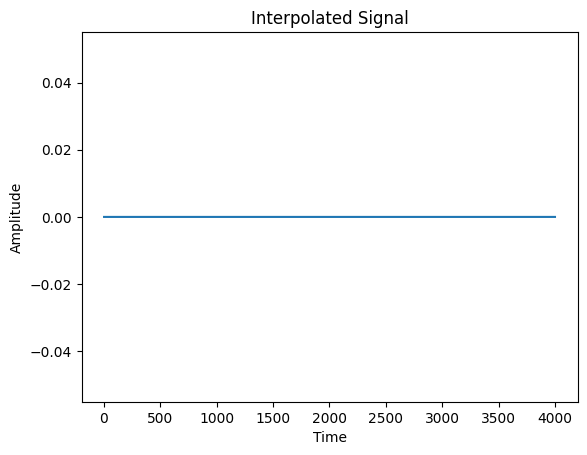

In [ ]:
# In this case, y_m_p is just the 
max_samples = mic_gt_signal.shape[0]# Sample size of mic_gt_signal
y_m_p = np.zeros((M, P, max_samples))  # Initialize with the maximum number of samples

# Interpolation point will be the same point as the ground truth microphone (Converting to 2D positions)
interp_point = np.array([mic_gt_pos[0], mic_gt_pos[1]])

# Compute the distance for all samples at once (This is the d_m function)
distances = np.array([compute_distance(interp_point, m, triangle_side) for m in range(M)])

# Compute the attenuation coefficients for each microphone using broadcasting (This calculates the a_p(d_m))
a_p_values = attenuation_and_rebalancing(distances[:, np.newaxis])

mic_1_signal = np.array(mic_1_signal)
mic_2_signal = np.array(mic_2_signal)
mic_3_signal = np.array(mic_3_signal)

# Fitting the y_m_p (p = 1, m is the mic)
y_1_1 = mic_1_signal
y_2_1 = mic_2_signal
y_3_1 = mic_3_signal

# Getting the attenuation values (a1_dm)
a1_d1 = a_p_values[0, :]
a1_d2 = a_p_values[1, :]
a1_d3 = a_p_values[2, :]

x_p = a1_d1 * y_1_1 + a1_d2 * y_2_1 + a1_d3 * y_3_1
x_p_shortened = x_p[start:end]

# Plotting x_p
time_axis = np.arange(1, 1 + x_p_shortened.shape[0])
wavfile.write('generated_mics/output_median4.wav', fs, x_p)
plt.plot(time_axis, x_p_shortened)
plt.title('Interpolated Signal')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()

# Checking if the centroid is the most like the ground truth by doing a cross-correlation graph

In [ ]:
# Performing cross correlation
from scipy.signal import correlate

# 1. Creating an array of y-value points (From y = 0 to y = 3)
# We expect 1.5 to be the highest
points =  [0, 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7]
num_points = len(points)
signals = []

# Array of cross correlation values
cross_corr_values = []

# Getting the values of cross_correlations
for i in range(num_points):
    y_point = points[i]
    interp_point = np.array([x_offset + triangle_side / 2, y_point])
    distances = np.array([compute_distance(interp_point, m, triangle_side) for m in range(M)])
    a_p_values = attenuation_and_rebalancing(distances[:, np.newaxis])

    # Getting the attenuation values (a1_dm)
    a1_d1 = a_p_values[0, :]
    a1_d2 = a_p_values[1, :]
    a1_d3 = a_p_values[2, :]

    x_p = a1_d1 * y_1_1 + a1_d2 * y_2_1 + a1_d3 * y_3_1

    # Normalizing x_p
    x_p_normalized = (x_p - np.mean(x_p)) / np.std(x_p)
    signals.append(x_p_normalized)


# Normalize the ground truth signal
gt_signal_normalized = (mic_gt_signal - np.mean(mic_gt_signal)) / np.std(mic_gt_signal)

# Cross correlating the signals
for signal in signals:
    cross_corr = correlate(gt_signal_normalized, signal, mode='full')
    cross_corr_values.append(cross_corr)

# Identifying time shifts
time_shifts = [np.argmax(cross_corr) - (len(gt_signal_normalized) - 1) for cross_corr in cross_corr_values]

# Quantifying similarities
max_corr_values = [np.max(cross_corr) for cross_corr in cross_corr_values]
print(f"Max correlation values: {max_corr_values}")

most_similar_index = np.argmax(max_corr_values)
most_similar_signal = signals[most_similar_index]

# We expect it to say 55
print(f"The most signal is the one with y value: {points[most_similar_index]}")


Max correlation values: [726845.2416203837, 728649.5975622168, 735130.4140320136, 741820.9362708251, 745678.0965523563, 745786.4876418676, 747364.8342177927, 750470.5837563142, 756627.6033523926, 763072.0831630509]
The most signal is the one with y value: 2.7


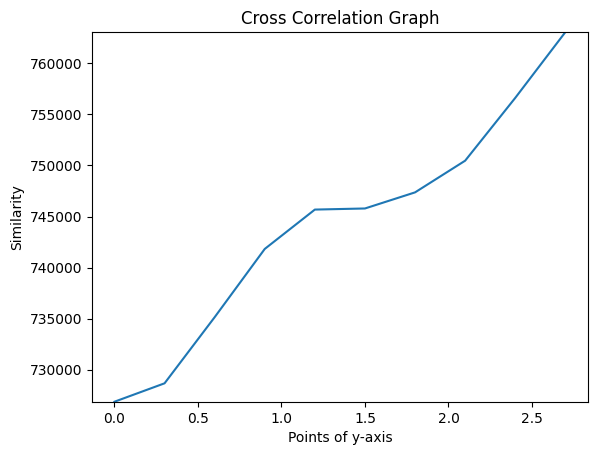

In [ ]:
# Normalize the max_corr_values:

# Plotting the graph
plt.plot(points, max_corr_values)
lower_bound = np.min(max_corr_values) - 0.0000000001
upper_bound = np.max(max_corr_values) + 0.0000000001
plt.ylim(lower_bound, upper_bound)
plt.title("Cross Correlation Graph")
plt.xlabel("Points of y-axis")
plt.ylabel("Similarity")
plt.show()
